In [1]:
%config Completer.use_jedi = False

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp , routing_parameters_pb2
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from Route_Optimizer import RouteOptimizer
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK10_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [3]:
station_coordinates

,Unnamed: 0,City Name,lat,long
0,0,Kingston_upon_Hull,53.743572,-0.339476
1,1,Pocklington,53.931568,-0.776104
2,2,Brough,54.526633,-2.317983
3,3,Selby,53.784012,-1.068781
4,4,Boughton,52.590018,0.508102
5,5,Barton_upon_Humber,53.673573,-0.442710
6,6,Darfield,53.535299,-1.376248
7,7,Bentley,51.989667,1.075096
8,8,Watton,52.569918,0.825349
9,9,Cudworth,53.573384,-1.419644


In [4]:
station_data

,City Name,Demand(kg),Ready Time(sec),Due Time(sec),Service Time(sec)
0,Kingston_upon_Hull,0,0,32400,0
1,Pocklington,721,2171,22139,1442
2,Brough,814,644,21053,1628
3,Selby,620,1049,20424,1240
4,Boughton,311,5119,24241,622
5,Barton_upon_Humber,167,2338,21697,334
6,Darfield,513,3675,24120,1026
7,Bentley,568,4401,25046,1136
8,Watton,763,3485,24335,1526
9,Cudworth,558,3740,24049,1116


In [5]:
#payload:8.5
#total w in tonnes:14
#l/100km empty :20-25
#l/100km full : 25-30
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15 #= meta_data.append({"Fuel Consumption Empty":12.5,"Fuel Consumption Full":15},ignore_index=True) 
meta_data

,Customer Amount,Vehicle Curb Weight(kg),Max Load(kg),Minimum Speed(km/h),Maximum Speed(km/h),F-C Empty (l/100km),F-C Full (l/100km)
0,10,6350,3650,20,90,12.5,15


In [6]:
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

distance_matrix_here,_ = generate_distance_matrix(points_coordinate,api)

## Construct data model parameters

In [7]:

vehicle_amount = 2

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy().tolist()
customer_demands[6] = 0
vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]

starts=[0,6]

ends = [0,0]


distance_matrix = make_open_problem(distance_matrix_here,starts)

#distance_matrix = make_open_problem(squareform(pdist(points_coordinate)),starts)

#depot = 0


data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
                   'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'startpoints':starts,'endpoints':ends}



# data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
#                    'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'depot':depot}


## Create data model

In [8]:
data = create_data_model_start_endpoints(**data_model_input)

In [9]:
pd.DataFrame(data['distance_matrix'])

,0,1,2,3,4,5,6,7,8,9,10
0,0,45436,207112,60243,199149,18881,0,355274,348887,94662,70883
1,0,0,151232,40816,342739,43528,0,346136,339749,90520,28043
2,0,150656,0,145180,427976,205415,0,443914,424986,165338,124482
3,0,40991,145518,0,325372,58295,0,328769,322382,49916,34495
4,0,237797,357810,220005,0,179512,0,90070,31561,213035,255398
5,0,44261,205937,59068,193895,0,0,348142,228923,93487,69708
6,0,88192,169037,54036,283088,93308,0,299026,280098,9101,80529
7,0,347222,444568,329430,90529,354777,0,0,84501,308551,356060
8,0,351012,425737,307643,31638,330205,0,83971,0,289720,337229
9,0,90085,164810,49809,291160,93166,0,307098,288170,0,76302


## Construct Simulated Annealing class

In [10]:
class Optimizer_SA(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.time_limit.seconds = 5
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_ARC)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
        return search_parameters

In [11]:
class Optimizer_TABU(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.time_limit.seconds = 10
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_ARC)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
        return search_parameters

In [12]:
class Optimizer_GLS(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.time_limit.seconds = 10
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_ARC)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        return search_parameters

## Set up constraints

In [13]:

def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def fuel_consumption_callback(from_index, to_index):
    """Returns the estimated fuel consumption between two nodes.
    Based on 'A Fuel Consumption Objective of VRP and the Genetic Algorithm' by Hao Xiong"""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    #Distance in 100km
    distance = (data['distance_matrix'][from_node][to_node])/1e5
    #Demand in kg
    demand = data['demands'][from_node]
    #Fuel consumption between nodes driving empty vehicle
    fuel_consumption_empty = distance * meta_data['F-C Empty (l/100km)']
    
    load_rate = demand / float(meta_data['Max Load(kg)'])
    
    #Additional fuel consumption when adding load at from_index
    fuel_consumption_load = distance * load_rate * (meta_data['F-C Full (l/100km)'] - meta_data['F-C Empty (l/100km)'])
    
    return fuel_consumption_empty + fuel_consumption_load
    
    


## Add constraints and weights. This should be turned in to functions in the future

In [20]:

# Create the routing index manager.
manager = create_routing_index_manager(data)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)
# ========== Add capacity cost & constraint to routing model ==========
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    dimension_name)
demand_dimension = routing.GetDimensionOrDie(dimension_name)
demand_dimension.SetGlobalSpanCostCoefficient(0)

# =====================================================================

# # ========== Add distance cost & constraint to routing model ==========
# transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# # Add Distance constraint.
# dimension_name = 'Distance'
# routing.AddDimension(
#     transit_callback_index,
#     0,  # no slack
#     250000000,  # vehicle maximum travel distance
#     True,  # start cumul to zero
#     dimension_name)
# distance_dimension = routing.GetDimensionOrDie(dimension_name)
# # Set distance weight to a high number since using coordinates
# distance_dimension.SetGlobalSpanCostCoefficient(0)
# # =====================================================================

# ========== Add fuel consumption cost & constraint to routing model ==========
fuel_callback_index = routing.RegisterTransitCallback(fuel_consumption_callback)
# Add Distance constraint.
dimension_name = 'Fuel Consumption'
routing.AddDimension(
    fuel_callback_index,
    0,  # no slack
    250000000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
fuel_dimension = routing.GetDimensionOrDie(dimension_name)
# Set distance weight to a high number since using coordinates
fuel_dimension.SetGlobalSpanCostCoefficient(1)
# =====================================================================

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(fuel_callback_index)
# Create callback object for storing cost values
callback = Callback(routing,demand_dimension)

In [21]:
# Add the data, manager, routing and callback to the optimizer
optimizerSA = Optimizer_SA(data)
optimizerSA.set_manager(manager)
optimizerSA.set_routing(routing)
optimizerSA.set_solution_callback(callback)

In [22]:
#https://github.com/google/or-tools/discussions/2263
# Initiate a solution collector for the optimizer
collector = optimizerSA.routing.solver().AllSolutionCollector()

#Create a IntVar for each node in the matrix and add to collector
for order_node in range(len(data["distance_matrix"])):
    index = manager.NodeToIndex(order_node)
    next_var = optimizerSA.routing.NextVar(index)
    #load_var = demand_dimension.CumulVar(index)
    #collector.Add(load_var)
    collector.Add(next_var)

# Add Collector to optimizer routing
optimizerSA.routing.AddSearchMonitor(collector)



## Solve problem

In [25]:
optimizerSA.solve_with_parameters()
collector.SolutionCount()

25

In [43]:
solutions = []
for solution_number in range(collector.SolutionCount()):
    sol_dict = {}
    sol =  collector.Solution(solution_number).IntVarContainer()
    for x in range(sol.Size()):
        from_var_str = str(sol.Element(x).Var())
        from_node = int(from_var_str[5])
        sol_dict[from_node] = sol.Element(x).Value() 
    solutions.append(sol_dict)
solutions

[{0: 5, 1: 12, 2: 3, 3: 1, 4: 8, 5: 9, 6: 2, 7: 4, 8: 11, 9: 7},
 {0: 5, 1: 12, 2: 3, 3: 1, 4: 8, 5: 9, 6: 2, 7: 11, 8: 7, 9: 4},
 {0: 5, 1: 12, 2: 3, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 2},
 {0: 5, 1: 12, 2: 1, 3: 2, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 2, 2: 12, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 1, 2: 12, 3: 10, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 2, 2: 12, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 1, 2: 12, 3: 10, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 2, 2: 12, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 1, 2: 12, 3: 10, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 2, 2: 12, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 1, 2: 12, 3: 10, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 2, 2: 12, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 1, 2: 12, 3: 10, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 2, 2: 12, 3: 1, 4: 8, 5: 4, 6: 9, 7: 11, 8: 7, 9: 3},
 {0: 5, 1: 1, 2: 12,

## Plot learning curve

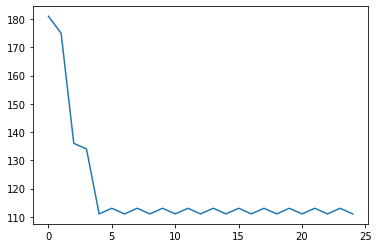

In [44]:
plt.plot(optimizerSA.solutionCallback.costs)

In [33]:
print(get_transit_route_costs(data,["distance_matrix"],optimizerSA.get_routes()))
print(get_unary_route_costs(data,["demands"],optimizerSA.get_routes()))

{'distance_matrix': [328308, 252590]}
{'demands': [1809, 3349]}


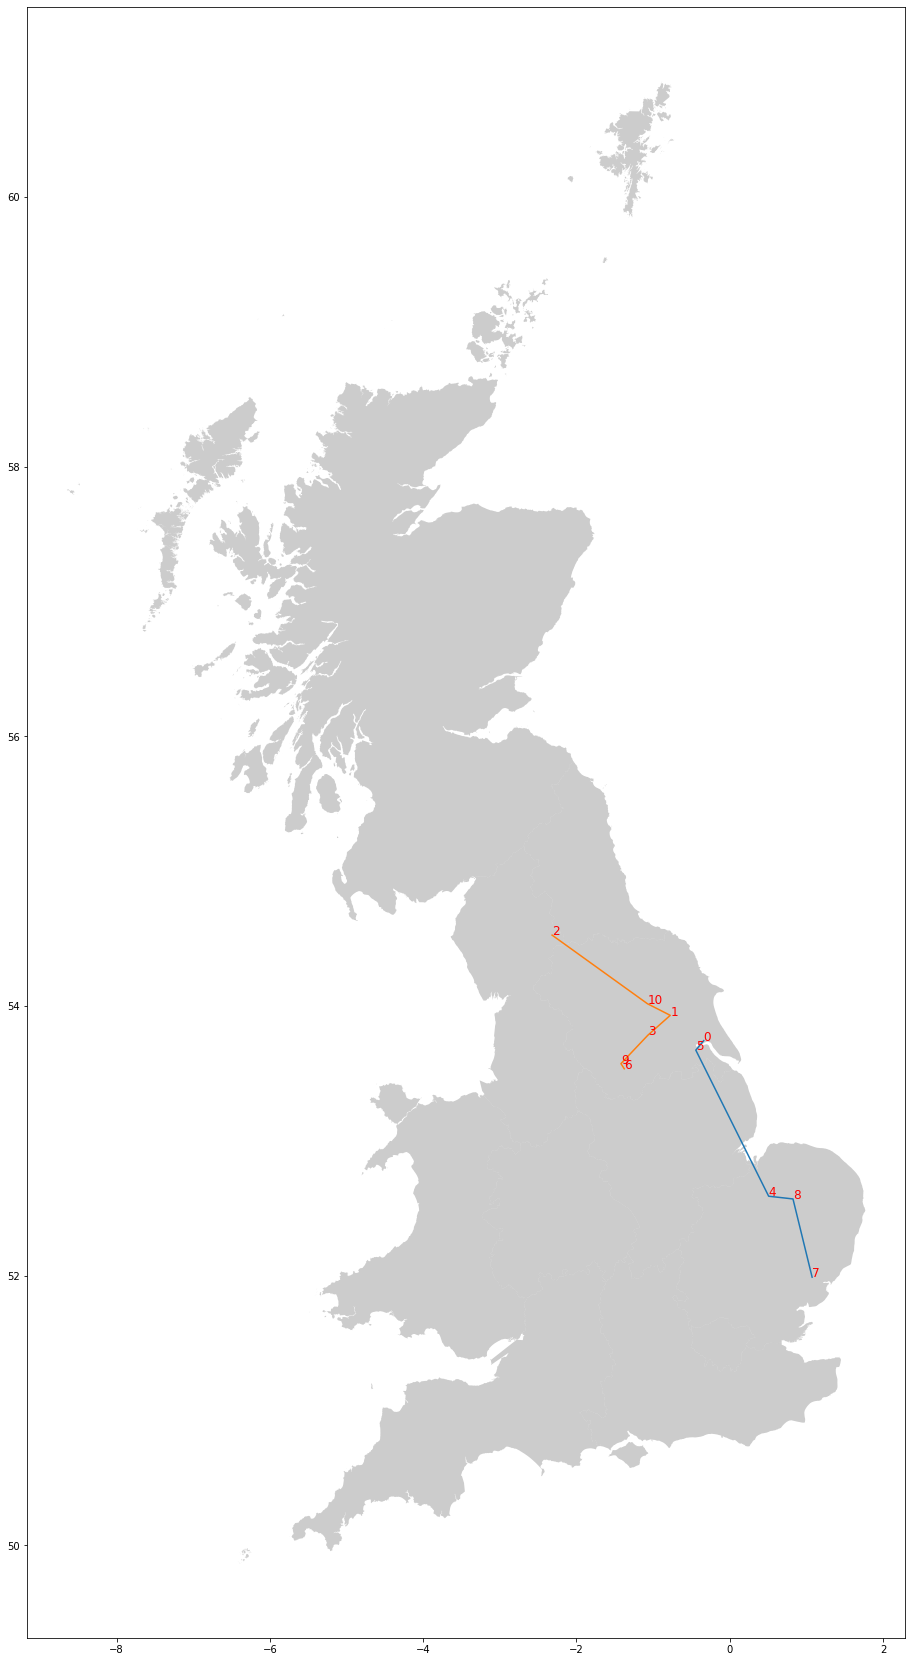

In [33]:
plot_routes(optimizerSA.get_routes(),points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

## Plot generated routes on map

100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


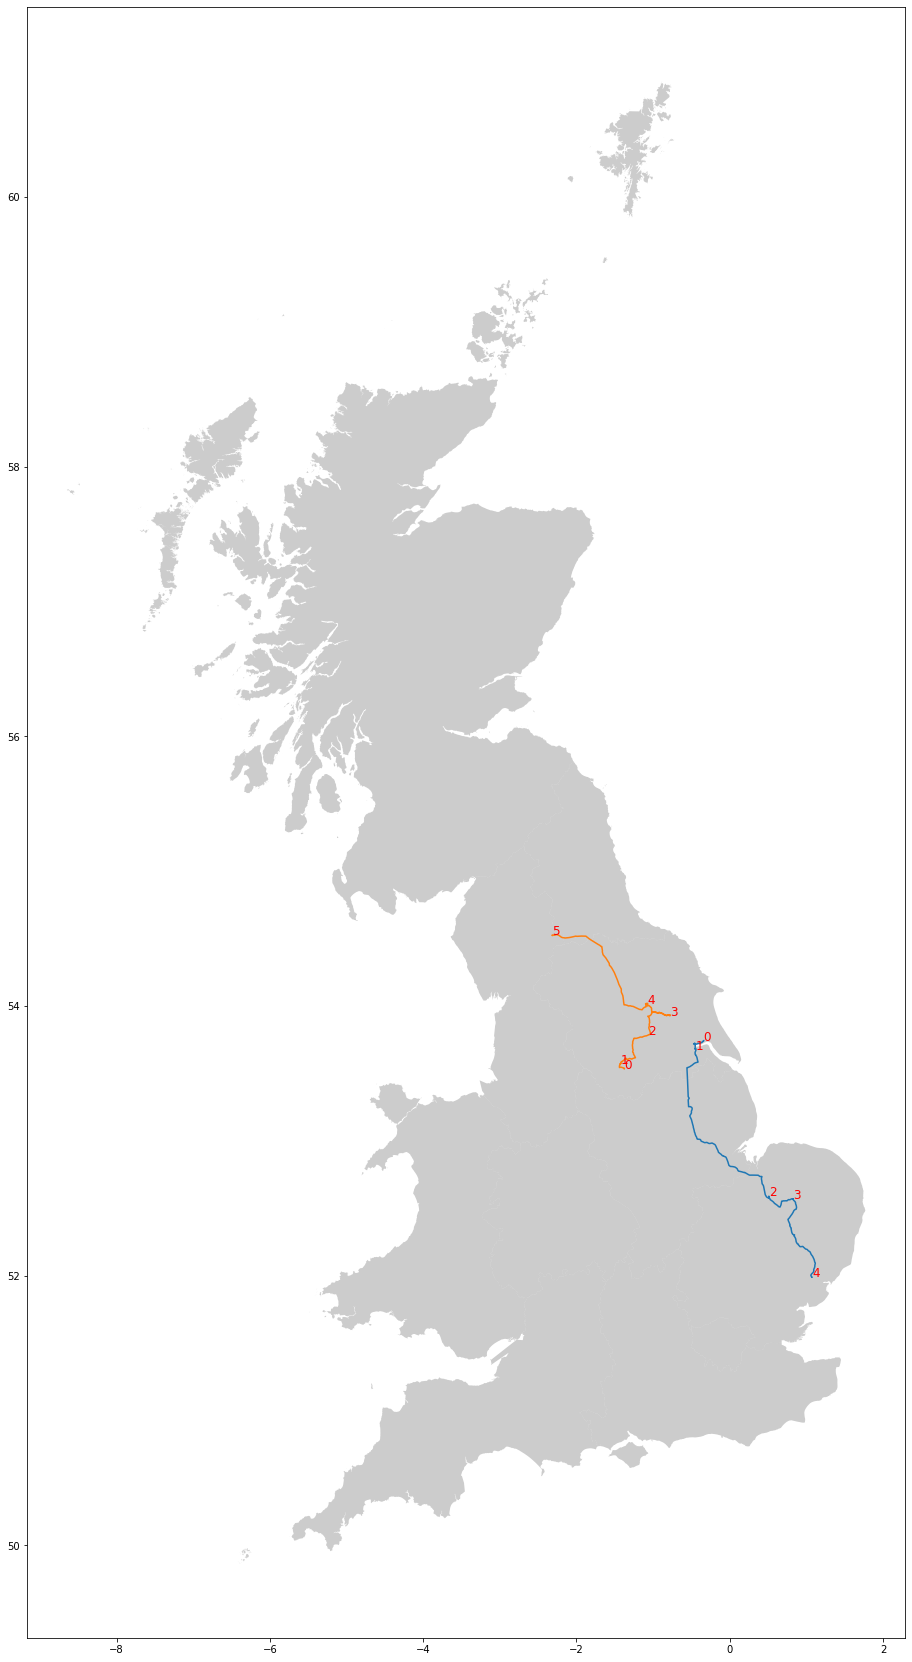

In [121]:
plot_routes(optimizerSA.get_routes(),points_coordinate,dbf,station_ids = False, here_api=True, api_key=api)

In [143]:
points_coordinate[optimizerSA.get_routes()[0]]

array([[53.7435722 , -0.3394758 ],
       [53.67357325, -0.44271004],
       [52.590018  ,  0.5081021 ],
       [52.5699185 ,  0.8253494 ],
       [51.989667  ,  1.075096  ]])

In [40]:
vehicle_routes = []
vehicle_stops = []

for v_route in optimizerSA.get_routes():
    vehicle_stops.append(points_coordinate[v_route])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))
    
    

100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


In [41]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
m_1 = folium.Map(location=points_coordinate[0], tiles='openstreetmap', zoom_start=8)
MarkerCluster(points_coordinate).add_to(m_1)
folium.PolyLine(vehicle_routes[0],color='red').add_to(m_1)
folium.PolyLine(vehicle_routes[1],color='blue').add_to(m_1)
# Display the map
m_1